In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first = True)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input_):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input_.view(len(input_), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [75]:
class Trainer(nn.Module):
    def __init__(self,input_size, hidden_size, batch_size, output_dim, num_layers, learning_rate):
        super(Trainer, self).__init__()
        self.model = LSTM(input_size, 
                          hidden_size, 
                          batch_size, 
                          output_dim, 
                          num_layers)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
    def predict(self, x_train):
        return self.model(x_train)
        
    def learn(self, y_pred, y_train):
        self.model.zero_grad()
#         self.model.hidden = self.model.init_hidden()
        loss = self.criterion(y_pred, y_train)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

<IPython.core.display.Javascript object>


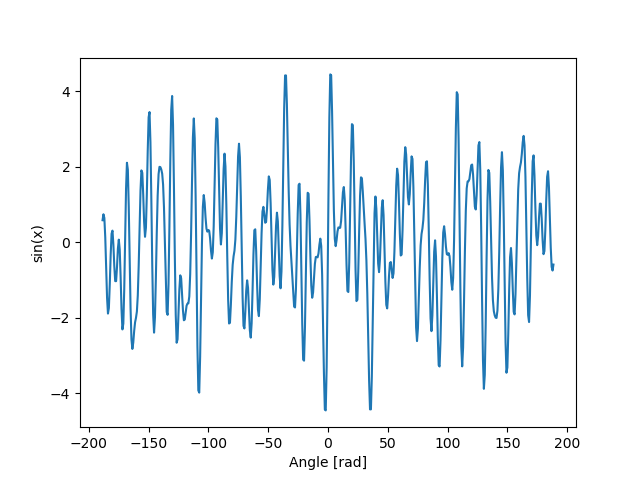

In [45]:
%matplotlib notebook
x = np.linspace(-60*np.pi, 60*np.pi, 500)
out = np.sin(x)+np.sin(0.71*x)+np.sin(0.12*x)+np.sin(0.32*x)+np.sin(0.66*x)+np.sin(0.48*x)
plt.plot(x, out)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [76]:
input_sequence_length = 20
output_predicted_length = 2
shift_per_batch = 1
epochs = 100
batch_size = 20

batch_num = (len(out)-input_sequence_length+shift_per_batch)/shift_per_batch - output_predicted_length

x = np.array([out[i:i+input_sequence_length] 
           for i in range(int(batch_num))])
y = np.array([out[i+input_sequence_length:i+input_sequence_length+output_predicted_length] 
           for i in range(int(batch_num))])

x_train = torch.from_numpy(x[:round(x.shape[0]*0.7),:])
x_test = torch.from_numpy(x[round(x.shape[0]*0.7):,:])
y_train = torch.from_numpy(y[:round(y.shape[0]*0.7),:])
y_test = torch.from_numpy(y[round(y.shape[0]*0.7):,:])

In [77]:
trainer = Trainer(input_size = input_sequence_length, 
                  hidden_size = 60,
                  batch_size = batch_size, 
                  output_dim = output_predicted_length, 
                  num_layers = 2, 
                  learning_rate = 0.01)

In [78]:
for t in range(epochs):
    for i in range(round(batch_num)):
        y_pred = trainer.predict(x_train[i*batch_size:(i+1)*batch_size,:])
        trainer.learn(y_pred,y_test[i*batch_size:(i+1)*batch_size,:])

RuntimeError: input.size(-1) must be equal to input_size. Expected 20, got 1